## Introduction

Welcome back to our deep learning adventure with fastai! In [Lesson 2](https://course.fast.ai/Lessons/lesson2.html), we dive into the exciting world of putting model into production. Whether you're a beginner looking to get your feet wet or an experienced practitioner wanting to brush up on your deployment skills, this lesson is packed with practical tips and hands-on techniques to take your models from the notebook to the real world.

In this blog post, we'll cover everything from gathering images to training and deploying models, using tools like Jupyter Notebooks, Gradio, and Hugging Face Spaces. Get ready to explore essential concepts like how to clean your data and see how different deployment platforms stack up against each other.

Buckle up and let's get started on this journey and bring your deep learning models to life!

## Gathering and Cleaning Data

In this section we'll walk through the process of gathering and cleaning data, leveraging some handy tools and methods introduced in Lesson 2.

### Importing and Setting Up

First ensure that you have all necessary libraries and modules in place. If you haven't already, run the following command to install the fastbook module:

```bash
conda install -y -c fastai fastbook
```

Now you can import the required functions from fastbook:

In [1]:
from fastbook import *
from fastai.vision.widgets import *

### Gathering Images with DuckDuckGo

Using DuckDuckGo(ddg) for image searches simplifies the process, as it doesn't require an API key. Here's the code to create our dataset of bear images:

In [2]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bear')
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f"{o} bear")
        download_images(dest, urls=results)

This code snippet sets up directories for different bear types and download images into respective folders.

Next, we verify and clean the downloaded images:

In [3]:
failed = verify_images(get_image_files(path))
failed

(#24) [Path('bear/black/b8d71ddf-a84d-4054-8088-bb08e8cbd814.jpg'),Path('bear/black/bbe19bf5-3d28-4d7e-b8bf-3e7f8afff5af.jpg'),Path('bear/teddy/ee833f9f-ff26-4435-a4cc-89208236c442.jpg'),Path('bear/teddy/f6f4f901-c873-46a6-8ef7-bbd65da2c910.jpg'),Path('bear/teddy/e3c4fc0d-e494-4c8a-9dc5-8510f8407cac.jpg'),Path('bear/teddy/3309df18-2a7f-4d67-b2e8-9f08eea06025.jpg'),Path('bear/teddy/99377b04-a870-4798-9e6a-02543a495395.JPG'),Path('bear/teddy/fbf4430d-0643-444b-a0c5-7d13c43d92b6.jpg'),Path('bear/teddy/4c576f46-fa7e-4800-bb89-9eea7662ab10.jpg'),Path('bear/teddy/50d2e017-49b9-49a1-9538-5e402932e463.jpg')...]

In [4]:
failed.map(Path.unlink);

This step ensures that any currupt images are identified and removed.

### Structuring Data with DataBlock API

We use `DataBlock` API to structure our data, making it ready for training: 

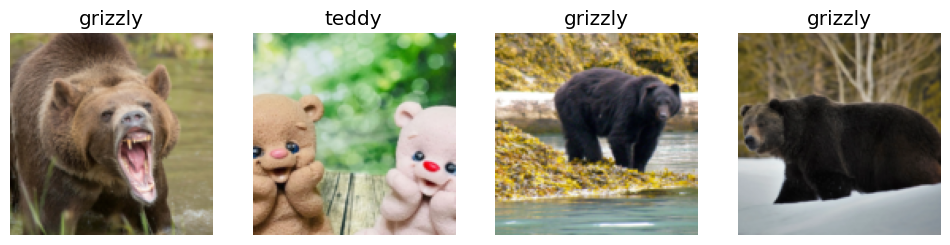

In [5]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

This show a batch of images using the default resizing method. Different resizing startegies can impact the dataset in various ways.

## Exploring Resizing Methods

Resizing plays a crucial role in preparing your images for model training. Let's explore three different resizing methods:

### Standard Resize

The standard resize method adjust the image size for model while maintaining a specific aspect rato. Here, we pad the images with zeros(black) to ensure the entire image is included:

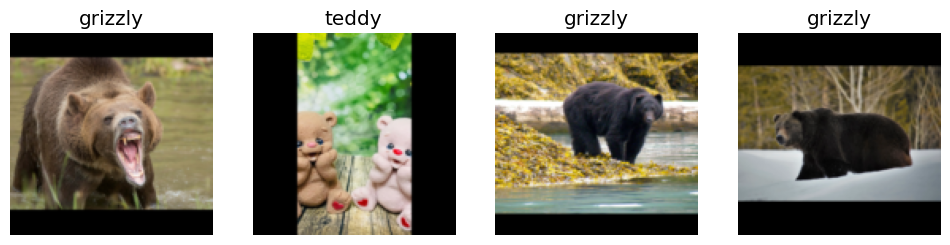

In [6]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

This approach, padding with zeros maintains the aspect rato and ensures that the entire image fit within the frame.

### RandomResizedCrop

Another effective method is `RandomResizedCrop`, which crops different parts of an image each time, providing varied views:

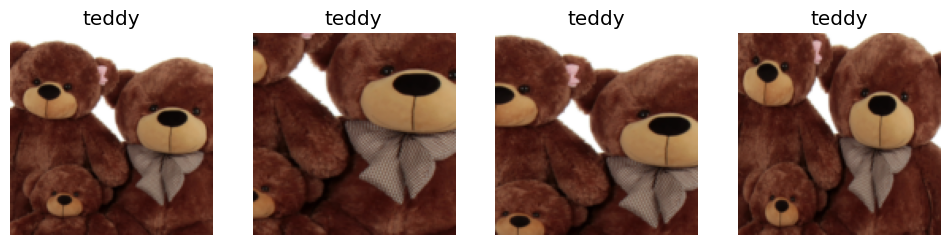

In [7]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

`RandomResizedCrop` is excellent for generating diverse training data. It explores different regions of the same image, enhancing the robustness of your model.

## Applying Data Augmentation

Data Augmentation increases the diversity of your training data by applying various transformations, such as rotation and flipping:

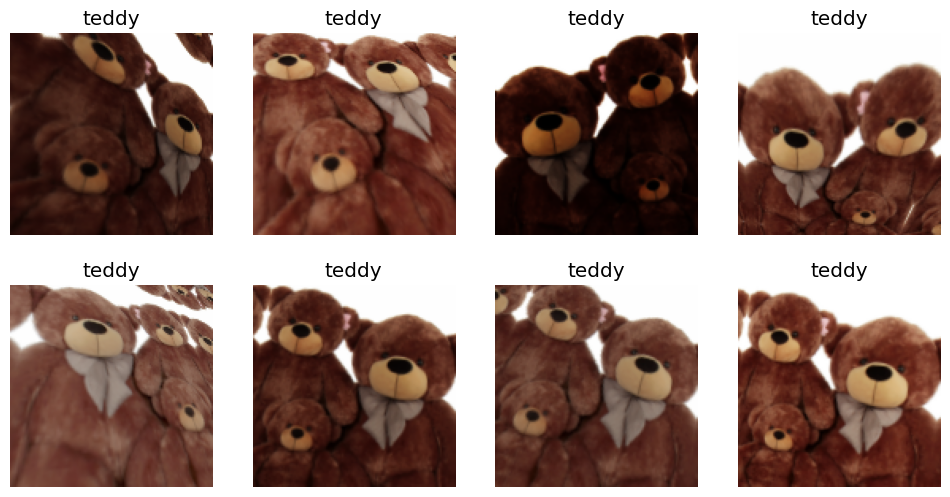

In [8]:
bears = bears.new(
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(mult=2)
)
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Using `aug_transforms`, we can dynamically modify images during training. This process, called data augmentation, helps the model generalize better by exposing it to various versions of the same image. The `mult=2` parameter exaggerates the transformations for better visualization.

## Training the Model

With our data ready, we can proceed to train a model using a pre-trained `resnet18`:

In [9]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = bears.dataloaders(path)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.010127,0.147814,0.066038,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.187663,0.105568,0.037736,00:13
1,0.165576,0.146279,0.037736,00:13
2,0.140621,0.171902,0.047170,00:14
3,0.117243,0.166212,0.047170,00:13


In this case we use `RandomSizedCrop` and `aug_transforms` to create robust data loaders. Training a model for four epochs results in an error rate of under five percent-quite impressive!

## Evaluating the Model

Evaluating the trained model is crucial for understanding its performance and identifying areas for improvement. Lesson 2 introduces several important techniques for model evaluation.

### Confusion Matrix Explanation

The confusion matrix is powerful tool for examining the performance of classification models. It provide insights into which categories are commonly confused by the model:

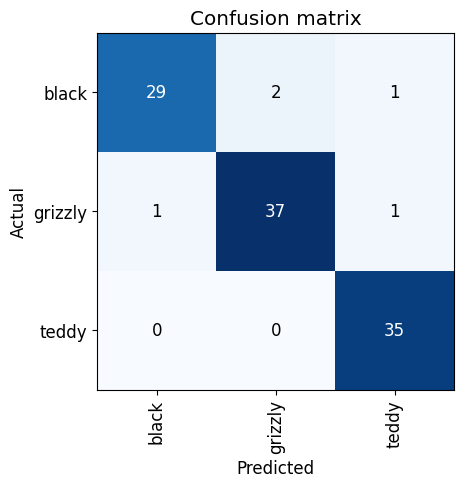

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The confusion matrix shows the model's predictions against the actual labels. Here's what it tells us:

- The diagonal represents correct predictions (e.g., 29 black bears correctly predicted as black bears).
- Off-diagonal elements reveal misclassifications (e.g., 2 black bears predicted as grizzly bears)

For instance, if our bear classifier mislabels a grizzly bear as a black bear, the corresponding cell in the matrix indicates how often this mistaken occurs. It's a visual representation of "where did we go wrong?" and is essential for refining the model.

Jeremy pointed out that such insight help:

- Identify which categories are inherently difficult to distinguish(e.g., black bears and grizzly bears).
- Understand if certain errors systematics and need targeted improvements.

Here's my model shows:

- **High accuracy in identifying grizzly bears and teddy bears**: There are only a couple of misclassification.
- **Some confusion between black bears and grizzly bears**: This is evident from the few off-diagonal elements

Understand these errors helps us focus on areas that need more training data or better distinguishing features. 

### `plot_top_losses` Explanation

The `plot_top_losses` function highlights the individual images where your model made the worst predictions:

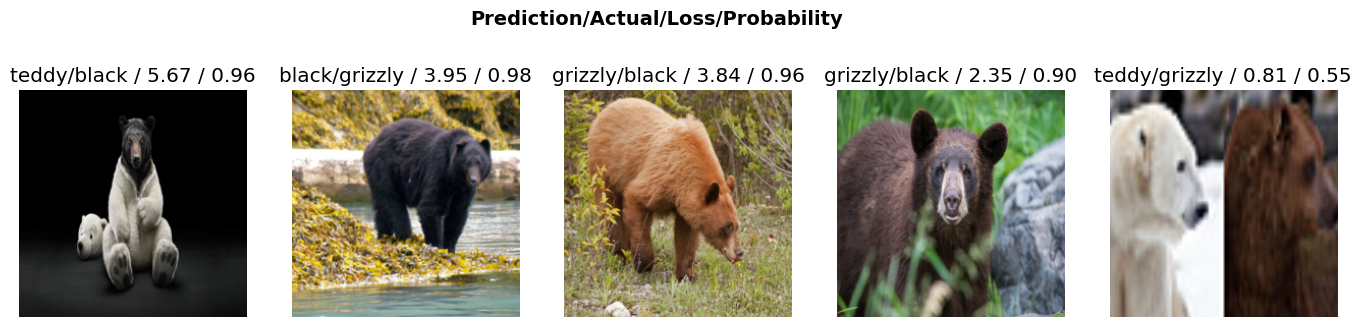

In [11]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

The results show specific cases where the model was either:

- **Highly confident but wrong**: E.g., the model predicted "teddy" with high confidence when it actually "black".
- **Correct but not confident**: E.g., predicting the right class but with low confidence.

By examining these top losses, you gain insights into why the model might be confused. Here, my model misclassified a black bear as a grizzly bear with high confidence which might indicate that the features used to distinguish between these classes are not prominent enough.

These insights can help in refining your data and possibly augmenting it to address these specific weaknesses.

## Clean the Data with `ImageClassifierCleaner`

Once we've evaluated our model, the next important step is data cleaning. Surprisingly, Jeremy suggests cleaning the data **after** training the initial model. This counterintuitive approach allows the model to highlight problematic data points

### `ImageClassifierCleaner` Demonstration

The `ImageClassifierCleaner` widget is a fantastic tool for this purpose. It helps you manually review and clean your dataset based on the model's predictions:

In [1]:
cleaner = ImageClassifierCleaner(learn)
cleaner

<img src="./cleaner_widget.png" style="width:100%;">


When you run this widget, it launches an interactive interface where you can:

- **Sort Image by Loss**: Images are ordered by the model's confidence, making it easy to identify incorrect or ambiguous labels.
- **Correct Labels**: Reassign images to the correct categories if they were mislabeled.
- **Delete Incorrect Images**: Remove images that don't belong in any category.

Jeremy explained how he used it to clean the bear dataset:

- By selecting "teddy bears", the widget displayed all images classified as teddy bears.
- He manually review the images, reassigning or deleting those that were incorrectly labeled.

Here's how you can apply the changes:

In [13]:
fns = get_image_files(path)
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

This code snippet updates the dataset based on your interaction with the `ImageClassifierCleaner`:
- **Delete**: Removes files marked for deletion.
- **Move**: Reassigns files to the correct categories.

### Why Clean After Training?

Cleaning the data after training might seems backward, but it has significant advantages:

- **Model-Assisted Cleaning**: The initial model helps identify problematic data points that might be hard to spot manually.
- **Focus on Hard Cases**: The confusion matrix and top losses highlight the hight areas that need most attention, making your cleaning effort more efficient.

This process ensures a high quality dataset for subsequent training iterations, leading to better model performance.

By incorporating thorough evaluation and cleaning steps, you refine you dataset and improve your model's accuracy and reliability. These insights are invaluable for building robust deep learning models that perform well on real-world data. 

## Deployment: Building and Deploying a Model

After cleaning our data, the next exciting step is to put our model into production. While [the book](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527) introduces Voilà for creating interactive web application using Jupyter Notebooks, there's another powerful tool that's becoming increasingly popular: **HuggingFace Spaces**. Together with **Gradio**, they offer an intuitive and powerful way to deploy machine learning models as web applications. 

### Introducing HuggingFace Spaces and Gradio.

HuggingFace Spaces is a platform that allows you to host machine learning model and their interfaces for free. On the other hand, Gradio make it easy to create customizable web interfaces with a few lines of Python code.

### A Shortout of Tanishq Abraham

Before diving into technical details, let's give a shortout to Tanishq Abraham, one of the most remarkable individuals in the fastai community. Known as a child prodigy, Tanishq has contributed immensely to the community, making complex topics accessible to everyone. I've learned a lot from his work and highly recommend checking out his [website](https://www.tanishq.ai/) and his [Twitter](https://x.com/iScienceLuvr) for more insightful resources.

Tanshiq has also written an excellent blog post the cover everything you need to know about using Gradio and HuggingFace Spaces. You can read his detail guide [here](https://www.tanishq.ai/blog/posts/2021-11-16-gradio-huggingface.html)

### Setting Up and Deploying Your Model using Gradio and HuggingFace Spaces

To deploy our model, we'll use HuggingFace Spaces. The set up process is straightforward and free of charge. Follow these step to get started:

**Step 1: Sign Up and Create a New Space**

1. Go to the [HuggingFace Spaces page](https://huggingface.co/spaces) and sign up for an account if you haven't already.

2. Click "Create a new space".
    
3. Give you space a name and chose a template (you can start with Gradio template).

Congrats! You've created a new space. Now, what's next?

**Step 2: Getting Familiar with Git**

HuggingFace Spaces works through Git, which many developers are already familiar with. Using Git is also a good practice, and Jeremy recommends using [Github Desktop](https://desktop.github.com/download/) and WSL2. Refer to the guide for [WSL2 installation](https://learn.microsoft.com/en-us/windows/wsl/install) to get started.

**Cloning the Repository**

To start working on HuggingFace Spaces you need to clone the repository locally, you have two options for cloning: **HTTPs** and **SSH**

| Pros / Cons | HTTPS | SSH |
|:--|:-----:|:-----:|
| **Pros** | Easier for beginners, no SSH key setup required | More secure, no need to enter credentials each time |
| **Cons** | Requires authentication each time you push | Requires SSH key setup |

: {.striped .hover}

Since I'm using SSH, if you follow along please make sure your SSH key is properly set up in your HuggingFace Spaces user setting

```bash
# Clone the repository using SSH
git clone git@huggingface.co:USERNAME/YOUR_REPO_NAME.git
cd YOUR_REPO_NAME
```
**Step 3: Prepare Your Model**

Make sure to export your trained model from the notebook:


In [ ]:
# in your bear classifier notebook
learn.export("model.pkl")

This saves the trained model as `model.pkl`, which you'll need for the deployment.

**Step 4: Building the Gradio Interface**

Gradio makes it easy to build an interactive interface. You can use Jupyter Notebook for experimentation and then use `nbdev.export.nb_export` to convert the notebook into Python script. This tool is very handy for such conversions. Alright, but first make sure you run `pip install gradio` in your terminal if you haven't already.

**1. Import Required Libraries**:

In [2]:
import gradio as gr
from fastai.vision.all import *

And so we can create a python image library image from that black bear

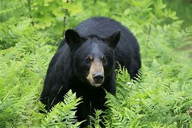

In [4]:
im = PILImage.create('black.jpg')
im.thumbnail((192, 192))
im

Turn it into slightly smaller one so it doesn't overwhelm my whole screen and there's is a picture of a black bear so we will use it for experimenting

**2. Load the Model**:

In [5]:
learn = load_learner('model.pkl')

One of the methods that the learner has is a `predict` method

In [6]:
learn.predict(im)

('black', tensor(0), tensor([9.9995e-01, 4.9545e-05, 3.8379e-06]))

So if you run it, you can see, even on a laptop, it's basically instant. It took a really short time to figure out this is a black bear

**3. Define the Prediction Function**:

Gradio requires us to give it a function that it's going to call but first we need to know what labels do we have?

In [7]:
learn.dls.vocab

['black', 'grizzly', 'teddy']

In [8]:
#create our categories
categories = learn.dls.vocab

So here's our function:

In [10]:
def classify_image(img):
    img = PILImage.create(img)
    pred, idx, probs = learn.predict(img)
    return dict(zip(categories, map(float, probs)))

So we called `predict` and that returns three things: the prediction as a string, the index of that, and the probabilities of whether it's black or grizzly or teddy bear. And what Gradio wants is it wants to get back a dictionary containing each of the possible categories-which is in this case grizzly, black and teddy bear-and the probabilities of each one. 

**4. Create the Gradio Interface**:

In [11]:
#| output: false
image = gr.Image(height=512, width=512)
labels = gr.Label()
examples = ["grizzly.jpg", "black.jpg", "teddy.jpg"]

intf = gr.Interface(fn=classify_image, inputs=image, outputs=labels, examples=examples)
intf.launch(inline=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


```
Running on local URL:  http://127.0.0.1:7860
To create a public link, set `share=True` in `launch()`.
```
![](huggingfacespaces.png)

This code creates a simple Gradio interface where user can upload images, and the model will predict whether it's a grizzly, black or teddy bear. you can run the interface inline in you Jupyter Notebook for testing.

**Step 5: Export the Notebook to a Python script**:

We will use nbdev to convert the Jupyter Notebook to a Python script.

**1. Add Metadata and Export Tags**:
    
    - Add `#| default_exp app` to the first cell
    - Add `#| export` to every cell you want to convert

**2. Run the Conversion**:

In [ ]:
import nbdev.export
nbdev.export.nb_export('app.ipynb', '.')

This command converts the notebook `app.ipynb` to a python script `app.py`.

**Step 6: Push Your Changes to HuggingFace Spaces**:

Handle large files like `model.pkl` using [Git LFS](https://git-lfs.com/) (Large File Storage).

**1. Set up Git LFS**:

In [ ]:
git lfs install
git lfs track "*.pkl"
git add .gitattributes
git commit -m "Track .pkl files with Git LFS" # To be honest, when initializing git lfs, the .gitattributes already supports .pkl files, and in my repo when initialized, it already had .gitattributes file. I don't know why, but I didn't need to commit it anyway, but I still write it here for the sake of completeness. 😉

**2. Commit and Push Your Changes**:

In [ ]:
git add .
git commit -m "Deploy bear classifier with Gradio interface🐻🎉"
git push

## Conclusion

By following this guide, you've successfully built and deployed your bear classifier using Gradio and HuggingFace Spaces. This powerful combination not only make you model accessible for everyone through the user-friendly web interface but also leverages cutting-edge tool to ensure it easy to maintain and extend.

Deploying machine learning models in real-world applications is an exciting milestone. It transform your hard work and complex algorithms into actionable insights and tools that can be used by anyone, anywhere. Whether you're a beginner or an experienced partitioner, the ability to take a model from Jupyter Notebook to a live web app is an invaluable skill in today's AI driven world.

In case you want to explore more about Gradio and HuggingFace, here are some valuable resources:

- **Gradio Documentation**: For more on Gradio, refer to the [Gradio documentation](https://www.gradio.app/docs/python-client/introduction).
- **My HuggingFace Spaces Bear Classifier**: Checkout my deployed bear classifier on HuggingFace Spaces [here](https://huggingface.co/spaces/TheMonarch/bear_classifier).
- **Tanishq Abraham's Blog**: For an in-depth look at deploying model using Gradio and HuggingFace Spaces, make sure to read Tanishq's excellent [blog post](https://www.tanishq.ai/blog/posts/2021-11-16-gradio-huggingface.html).

Although I initially planned to look into the HuggingFace Spaces API and deploying your own web app via JavasScript, sometimes technical hitches happened. Whether it's a client-side issue or just part of the learning curve, don't let it discourage you. Every challenge is learning opportunity, and with the fast-placed advancements in AI and deployment tools, there's always something new and exciting around the corner.

Thank you for joining me on this journey to bring deep learning model to life. Embrace the power of open-source tools, keep experimenting, and never stop learning. Happy coding, and may your models always be accurate!